**NAMA : ZULFAA DWI OKTAVIAN** <br>
**Email: a406ybm522@devacademy.id** <br>
**ID   : A406YBM522**

In [1]:
import os
import sys

# Menonaktifkan log TensorFlow (hanya menampilkan ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' (default), '1' (INFO), '2' (WARNING), '3' (ERROR)

# Menonaktifkan log CUDA/NVIDIA terkait NUMA
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Pilih GPU tertentu atau kosongkan (' ') untuk hanya pakai CPU
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['NVIDIA_LOGS'] = '0'

# Menonaktifkan stderr untuk menyembunyikan log tambahan dari TensorFlow dan CUDA
sys.stderr = open(os.devnull, 'w')

import re
import string
import requests
import csv
import joblib
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi

import nltk
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score,  classification_report

import optuna
import joblib

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, Input, BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Business Understanding
Proyek ini bertujuan untuk menganalisis sentimen pengguna terhadap aplikasi Gojek berdasarkan ulasan yang diambil dari Google Play Store. Gojek dipilih karena merupakan salah satu aplikasi layanan on-demand terbesar di Indonesia, yang menyediakan berbagai layanan mulai dari transportasi, pemesanan makanan, pembayaran digital, hingga layanan keuangan. Karena cakupan layanannya yang luas dan banyak digunakan oleh masyarakat, persepsi pengguna terhadap aplikasi ini sangat beragam dan menjadi sumber informasi berharga bagi pengembangan produk dan peningkatan layanan.

Data dikumpulkan melalui proses scraping menggunakan library google-play-scraper di Python. Ulasan-ulasan yang diperoleh kemudian diproses dan dianalisis menggunakan pendekatan Machine Learning dan Deep Learning untuk mengklasifikasikan sentimen menjadi positif, negatif, atau netral. Analisis ini bertujuan untuk mengetahui pola umum dalam kepuasan atau ketidakpuasan pengguna, serta mengevaluasi metode klasifikasi mana yang paling efektif dalam memahami opini pelanggan.



# Data Understanding

## Data hasil scrapping GOJEK

In [2]:
df = pd.read_csv('ulasan_aplikasi_gojek.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,7cc289d2-e914-459f-a5a1-33b1128b6602,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi banyak promo,5,0,5.18.2,2025-05-09 09:16:44,NaN,NaN,5.18.2
1,ccda1819-b490-4851-9c22-f0eb3550406f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baik,5,0,5.18.2,2025-05-09 09:15:29,NaN,NaN,5.18.2
2,0b0539db-6f17-4bbd-a51a-653d86c7ee01,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap,5,0,5.18.2,2025-05-09 09:15:03,NaN,NaN,5.18.2
3,30e38f11-70cb-48d5-91f9-a253016f7a63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,best cuyyy,5,0,5.18.2,2025-05-09 09:09:45,NaN,NaN,5.18.2
4,0a2da84e-3699-48ec-b723-dd364cff19a3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,5.18.2,2025-05-09 09:03:51,NaN,NaN,5.18.2


score
5    718864
1    194491
4     70349
3     42960
2     35336
Name: count, dtype: int64


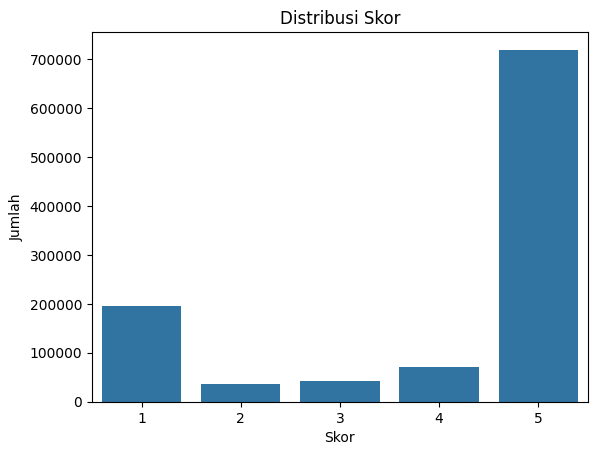

In [3]:
# Menampilkan jumlah nilai unik pada kolom 'score'
print(df['score'].value_counts())

# Membuat visualisasi jumlah nilai unik pada kolom 'score'
sns.countplot(x='score', data=df)
plt.title('Distribusi Skor')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.show()

# Preprocessing Data

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence
    

In [7]:
df['content'] = df['content'].fillna('')      # Ganti NaN jadi string kosong
df['content'] = df['content'].astype(str)     # Paksa semua jadi string

In [5]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [8]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_casefoldingText'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

## Pelabelan

In [9]:
# Loads positive lexicon data from GitHub
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Loads negative lexicon data from GitHub
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya ke dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [10]:
# Function to determine sentiment polarity of tweets
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            #score -= 0.5 * lexicon_negative[word]  # kasih penalti yang lebih ringan

            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    else:
        polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan
    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks


In [11]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
positive    467025
neutral     309325
negative    285650
Name: count, dtype: int64


## Visualisasi Hasil Pelabelan

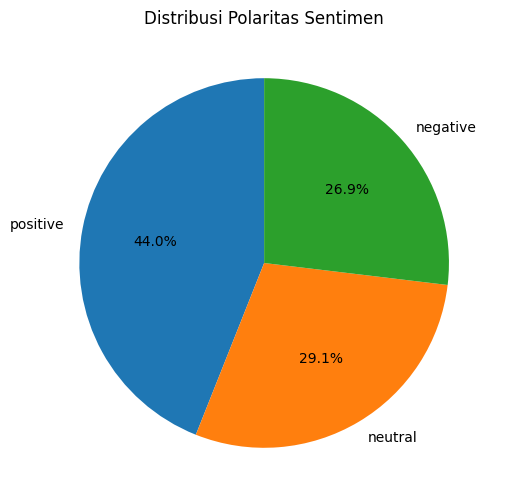

In [32]:
# Menghitung jumlah setiap nilai dalam kolom 'polarity'
polarity_counts = df['polarity'].value_counts()

# Membuat plot pie
plt.figure(figsize=(8, 6))  # Mengatur ukuran plot
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Polaritas Sentimen')  # Menambahkan judul plot
plt.show()  # Menampilkan plot

In [13]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = df[df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

In [14]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = df[df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1

In [15]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
neutral_tweets = df[df['polarity'] == 'neutral']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
neutral_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
neutral_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
neutral_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
neutral_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
neutral_tweets.index += 1

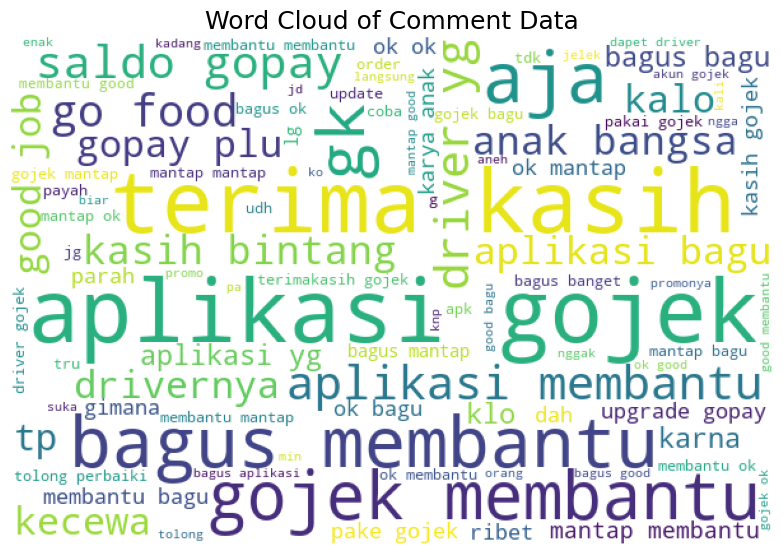

In [16]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'df'.
for tweet in df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Comment Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

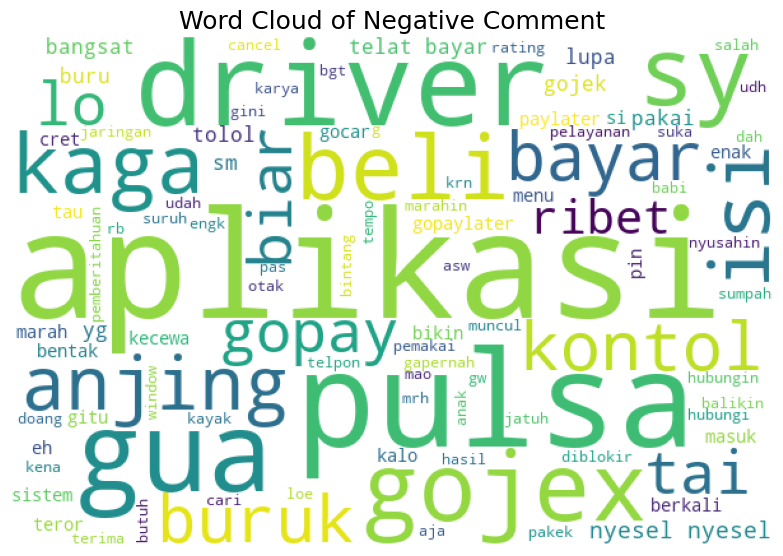

In [17]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Comment', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

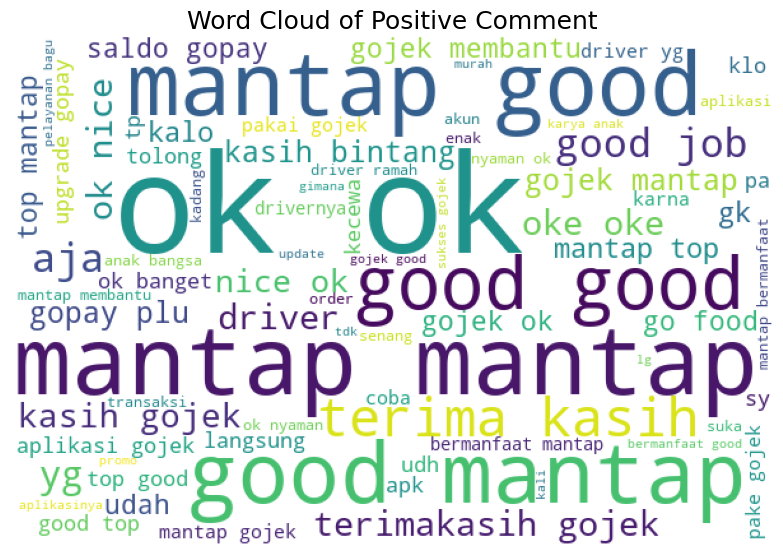

In [18]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet positif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Positive Comment', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

Berdasarkan visualisasi word cloud dari ulasan pengguna aplikasi Gojek di Google Play Store, dapat diperoleh gambaran umum mengenai persepsi pengguna terhadap aplikasi tersebut. Pada word cloud untuk komentar negatif, kata-kata seperti “driver”, “pulsa”, “beli”, “gopay”, dan “aplikasi” muncul cukup dominan, yang menunjukkan bahwa banyak keluhan berkaitan dengan sistem pembayaran, transaksi digital, serta layanan dari mitra driver. Selain itu, munculnya kata-kata kasar seperti “anjing”, “kontol”, dan “tai” mencerminkan luapan emosi negatif dari pengguna yang merasa sangat kecewa terhadap pengalaman mereka, baik itu karena kendala teknis, layanan buruk, maupun kesulitan dalam menggunakan aplikasi (ribet).

Sementara itu, word cloud dari komentar positif menunjukkan kata-kata dominan seperti “mantap”, “good”, “ok”, “terima kasih”, dan “bermanfaat”. Ini mengindikasikan bahwa banyak pengguna merasa puas terhadap layanan Gojek secara keseluruhan. Ucapan apresiasi ini juga menunjukkan bahwa fitur-fitur seperti GoPay, layanan pemesanan transportasi, dan GoFood dinilai membantu serta mempermudah kehidupan sehari-hari pengguna. Keberadaan kata seperti “driver” dalam konteks positif juga mengindikasikan bahwa sebagian pengguna mengapresiasi sikap dan pelayanan dari para mitra pengemudi.

Secara keseluruhan, analisis ini memperlihatkan bahwa meskipun Gojek mendapat banyak pujian atas manfaat dan kemudahan yang ditawarkan, masih terdapat aspek-aspek penting seperti sistem pembayaran dan kualitas layanan driver yang perlu diperhatikan untuk meningkatkan kepuasan pengguna secara menyeluruh.

## Membuat folder output

In [20]:
os.makedirs('Model GOJEK')

## Definisi Vektor Kalimat

In [21]:
def getVektorKalimat(sentence, model):
    vectors = [model.wv[word] for word in sentence.split() if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

## Splitting Data

In [ ]:
def persiapanData(datasetClean, skema):
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(datasetClean['text_akhir'], datasetClean['polarity'], stratify=datasetClean['polarity'], test_size=0.2, random_state=42)
    
    if skema['ekstraksiFitur'] == 1 and skema['model'] == 1:
        vectorizer = TfidfVectorizer()
        
        # Fit dan transform data training
        x_train_baru = vectorizer.fit_transform(x_train)
        x_test_baru = vectorizer.transform(x_test)
        
        # Simpan vectorizer dengan nama sesuai skema
        joblib.dump(vectorizer, f"Model GOJEK/tfidf_vectorizer_{skema['nama']}.pkl")
    else:
        # Tokenisasi untuk Word2Vec
        tokenized_sentences = [sentence.split() for sentence in datasetClean['text_akhir']]
        embedding_dim = 100 # Vector Size untuk Word2Vec sekaligus layer embbeding di BiLSTM
        
        # Latih model Word2Vec
        word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
        
        # Simpan model Word2Vec dengan nama sesuai skema
        word2vec_model.save(f"word2vec_model_{skema['nama']}.model")

        # Konversi data ke vektor menggunakan Word2Vec
        x_train_baru = np.array([getVektorKalimat(sentence, word2vec_model) for sentence in x_train])
        x_test_baru = np.array([getVektorKalimat(sentence, word2vec_model) for sentence in x_test]) 
        
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)  
    y_test = label_encoder.transform(y_test)
    
    # Simpan label encoder dengan nama sesuai skema
    joblib.dump(label_encoder, f"label_encoder_{skema['nama']}.pkl")
    
    # Tampilkan pemetaan label encoding
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label Mapping:", label_mapping) 
    
    if skema['model'] == 2:
        # Sesuaikan input untuk LSTM: (samples, timesteps, features)
        X_train = x_train_baru.reshape((x_train_baru.shape[0], 1, x_train_baru.shape[1]))
        X_test = x_test_baru.reshape((x_test_baru.shape[0], 1, x_test_baru.shape[1]))

        # Cek bentuk akhir
        print(X_train.shape)
        print(X_test.shape)
    else:
        X_train = x_train_baru
        X_test = x_test_baru
    
    return X_train, X_test, y_train, y_test

# Pembuatan Model

In [ ]:
def modellingSkema(skema, X_train, X_test, y_train, y_test, save_path="Model GOJEK/"):
    results = []
    print(f"========Running Model untuk Skema Pengujian : {skema['nama']}==========")
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # MODEL KLASIK (TF-IDF / Word2Vec flat vector)
    if skema['model'] == 1:
        def objective(trial):
            C = trial.suggest_float("C", 0.01, 10.0, log=True)
            solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
            model = LogisticRegression(C=C, solver=solver, penalty='l2', max_iter=1000, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            return f1_score(y_test, y_pred, average='macro')

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=15)
        best_params = study.best_params
        
        best_model = LogisticRegression(**best_params, penalty='l2', max_iter=1000, random_state=42)
        best_model.fit(X_train, y_train)
        
        # Save model
        model_path = f"{save_path}logreg_{skema['nama'].replace(' ', '_')}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model Logistic Regression disimpan di: {model_path}")

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

    # MODEL BiLSTM (hanya digunakan jika ekstraksiFitur = Word2Vec)
    else:
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])

        print("Compile Model : ")
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=256, verbose=1)

        model_path = f"{save_path}lstm_{skema['nama'].replace(' ', '_')}.h5"
        model.save(model_path)
        print(f"Model LSTM disimpan di: {model_path}")

        y_pred_train = np.argmax(model.predict(X_train), axis=1)
        y_pred_test = np.argmax(model.predict(X_test), axis=1)
    
    # Evaluation
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1_macro = f1_score(y_train, y_pred_train, average='macro')
    train_balanced_acc = balanced_accuracy_score(y_train, y_pred_train)
    print("\nClassification Report Train : ")
    print(classification_report(y_train, y_pred_train))

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1_macro = f1_score(y_test, y_pred_test, average='macro')
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_test)
    print("\nClassification Report Test : ")
    print(classification_report(y_test, y_pred_test))

    results.append({
        'Skema Pengujian': skema['nama'],
        'Train Accuracy': train_accuracy,
        'Train F1 Score (Macro)': train_f1_macro,
        'Train Balanced Accuracy': train_balanced_acc,
        'Test Accuracy': test_accuracy,
        'Test F1 Score (Macro)': test_f1_macro,
        'Test Balanced Accuracy': test_balanced_acc,
        'Model Path': model_path
    })
    
    return results


In [27]:
skema = [
    {
        'nama': 'Pemodelan Logistic Regression dengan TF-IDF',
        'ekstraksiFitur': 1,
        'model': 1
    },
    {
        'nama': 'Pemodelan Logistic Regression dengan Word2Vec',
        'ekstraksiFitur': 2,
        'model': 1
    },
    {
        'nama': 'Pemodelan BiLSTM dengan Word2Vec',
        'ekstraksiFitur': 2,
        'model': 2    
    }
]

hasilFinal = []

1. Logistic Regression dengan TF-IDF
Menggunakan TF-IDF untuk merepresentasikan frekuensi kata dan Logistic Regression untuk klasifikasi sentimen.

2. Logistic Regression dengan Word2Vec
Menggabungkan representasi kata berbasis makna (Word2Vec) dengan model klasifikasi Logistic Regression.

3. BiLSTM dengan Word2Vec
Menggunakan Word2Vec sebagai input dan BiLSTM untuk menangkap konteks dua arah dalam klasifikasi sentimen.

## Skema 1

In [28]:
X_train, X_test, y_train, y_test = persiapanData(df, skema[0])
result = modellingSkema(skema[0], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
========Running Model untuk Skema Pengujian : Pemodelan Logistic Regression dengan TF-IDF==========
Model Logistic Regression disimpan di: Model GOJEK/logreg_Pemodelan_Logistic_Regression_dengan_TF-IDF.pkl

Classification Report Train : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    228520
           1       1.00      0.98      0.99    247460
           2       0.99      1.00      1.00    373620

    accuracy                           0.99    849600
   macro avg       0.99      0.99      0.99    849600
weighted avg       0.99      0.99      0.99    849600


Classification Report Test : 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     57130
           1       0.97      0.97      0.97     61865
           2       0.99      0.99      0.99     93405

    accuracy                           0.98    212400
   macro avg      

## Skema 2

In [29]:
X_train, X_test, y_train, y_test = persiapanData(df, skema[1])
result = modellingSkema(skema[1], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
========Running Model untuk Skema Pengujian : Pemodelan Logistic Regression dengan Word2Vec==========
Model Logistic Regression disimpan di: Model GOJEK/logreg_Pemodelan_Logistic_Regression_dengan_Word2Vec.pkl

Classification Report Train : 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    228520
           1       0.82      0.83      0.83    247460
           2       0.86      0.84      0.85    373620

    accuracy                           0.82    849600
   macro avg       0.82      0.82      0.82    849600
weighted avg       0.82      0.82      0.82    849600


Classification Report Test : 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     57130
           1       0.82      0.83      0.83     61865
           2       0.86      0.84      0.85     93405

    accuracy                           0.82    212400
   macro avg  

## Skema 3

In [30]:
X_train, X_test, y_train, y_test = persiapanData(df, skema[2])
result = modellingSkema(skema[2], X_train, X_test, y_train, y_test)
hasilFinal.extend(result)

Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
(849600, 1, 100)
(212400, 1, 100)
========Running Model untuk Skema Pengujian : Pemodelan BiLSTM dengan Word2Vec==========
Compile Model : 
Epoch 1/25
3319/3319 [==============================] - 224s 40ms/step - loss: 0.3508 - accuracy: 0.8629 - val_loss: 0.2706 - val_accuracy: 0.8946
Epoch 2/25
3319/3319 [==============================] - 121s 36ms/step - loss: 0.2942 - accuracy: 0.8869 - val_loss: 0.2541 - val_accuracy: 0.9020
Epoch 3/25
3319/3319 [==============================] - 137s 41ms/step - loss: 0.2798 - accuracy: 0.8930 - val_loss: 0.2419 - val_accuracy: 0.9079
Epoch 4/25
3319/3319 [==============================] - 148s 45ms/step - loss: 0.2719 - accuracy: 0.8963 - val_loss: 0.2400 - val_accuracy: 0.9067
Epoch 5/25
3319/3319 [==============================] - 104s 31ms/step - loss: 0.2656 - accuracy: 0.8987 - val_loss: 0.2333 - val_accuracy: 0.9113
Epoch 6/25
3319/3319 [==============================] - 125s 38ms

## Evaluasi

In [31]:
pd.DataFrame(hasilFinal)

,Skema Pengujian,Train Accuracy,Train F1 Score (Macro),Train Balanced Accuracy,Test Accuracy,Test F1 Score (Macro),Test Balanced Accuracy,Model Path
0,Pemodelan Logistic Regression dengan TF-IDF,0.992687,0.992192,0.991828,0.979237,0.977965,0.977907,Model GOJEK/logreg_Pemodelan_Logistic_Regression_dengan_TF-IDF.pkl
1,Pemodelan Logistic Regression dengan Word2Vec,0.823463,0.817534,0.818947,0.823446,0.817644,0.819081,Model GOJEK/logreg_Pemodelan_Logistic_Regression_dengan_Word2Vec.pkl
2,Pemodelan BiLSTM dengan Word2Vec,0.925757,0.923330,0.924668,0.920734,0.918245,0.919555,Model GOJEK/lstm_Pemodelan_BiLSTM_dengan_Word2Vec.h5


**Interpretasi** <br>

1. Logistic Regression dengan TF-IDF
Performa terbaik di semua metrik (akurasi, F1, balanced accuracy). TF-IDF sangat efektif untuk model klasik seperti Logistic Regression. Overfitting kecil (train dan test score cukup dekat). <br>

2. Logistic Regression dengan Word2Vec
Performa terendah di antara ketiganya. Word2Vec tidak terlalu optimal dengan Logistic Regression karena mengurangi informasi distribusi kata. Agregasi vektor (rata-rata) mungkin terlalu sederhana. <br>

3. BiLSTM dengan Word2Vec
Performa tinggi dan stabil, mendekati model TF-IDF + Logistic Regression. BiLSTM mampu menangkap urutan dan konteks kata, sehingga Word2Vec dimanfaatkan dengan baik.

## Deployment 

In [39]:
def preprocess_text(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    sentence = toSentence(tokens)
    stemmed = stemmingText(sentence)
    return stemmed

# Load model dan vectorizer
model = joblib.load("Model GOJEK/logreg_Pemodelan_Logistic_Regression_dengan_TF-IDF.pkl")
vectorizer = joblib.load("Model GOJEK/tfidf_vectorizer_Pemodelan Logistic Regression dengan TF-IDF.pkl")

# Label mapping
label_mapping = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

def predict_from_input():
    user_input = input("Masukkan teks untuk prediksi: ")
    
    # Preprocessing input pengguna
    processed_text = preprocess_text(user_input)
    
    # Transformasi teks ke vektor TF-IDF
    text_tfidf = vectorizer.transform([processed_text])
    
    # Lakukan prediksi dengan model
    prediction = model.predict(text_tfidf)
    
    # Konversi hasil prediksi ke label
    predicted_label = label_mapping[int(prediction[0])]
    
    print(f"Teks yang dimasukkan: {user_input}")
    print(f"Hasil prediksi: {predicted_label}")

In [43]:
predict_from_input()

Teks yang dimasukkan: Sangat bagus dan bermanfaat
Hasil prediksi: Positif


In [41]:
predict_from_input()

Teks yang dimasukkan: Tes
Hasil prediksi: Netral


In [42]:
predict_from_input()

Teks yang dimasukkan: Aplikasi buruk jelek
Hasil prediksi: Negatif


In [2]:
# Membuat file requirements.txt berdasarkan paket yang sedang digunakan
!pip freeze > requirements.txt

# Menampilkan isi requirements.txt
!cat requirements.txt